<a href="https://colab.research.google.com/github/jdasam/aat3020/blob/main/notebooks/3_Language_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


# Language modeling

In [3]:
!wget "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"

--2024-05-09 06:06:37--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.004s  

2024-05-09 06:06:37 (61.7 MB/s) - ‘names.txt’ saved [228145/228145]



In [4]:
def read_txt(txt_path):
  with open(txt_path, 'r') as f:
    txt_string = f.readlines()
  return txt_string

txt_string = read_txt('names.txt')

In [5]:
names_list = [x.replace('\n', '') for x in txt_string]
len(names_list)

32033

# N-Gram
- Start with bi-gram (2-gram)

In [6]:
from collections import defaultdict

# bigram_dict = {}
bigram_dict = defaultdict(int) # If key is not in the defaultdict, it automatically assign key and empty value (int=0, list=[])
unigram_dict = defaultdict(int)

def split_word_for_ngram(word: str, n: int = 2, add_special_token:bool = True):
  output = []
  if add_special_token:
    word = '#' + word + '#'
  for i in range(len(word)-n+1):
    output.append(word[i:i+n])
  return output

print(split_word_for_ngram('emanuel', n=2))

for name in names_list:
  ngram_of_word = split_word_for_ngram(name, n=2)
  for ngram in ngram_of_word:
    bigram_dict[ngram] += 1
    # if ngram in bigram_dict:
    #   bigram_dict[ngram] += 1  # key is ngram, and value is count
    # else:
    #   bigram_dict[ngram] = 1
  ngram_of_word = split_word_for_ngram(name, n=1)
  for ngram in ngram_of_word:
    unigram_dict[ngram] += 1

len(bigram_dict), len(unigram_dict)

['#e', 'em', 'ma', 'an', 'nu', 'ue', 'el', 'l#']


(627, 27)

In [7]:
# P(m|e) = P(em) / P(e)
unique_alphabet = sorted(list(unigram_dict.keys()))

transition_mat = torch.zeros(len(unique_alphabet), len(unique_alphabet))
transition_mat.shape

for i, char in enumerate(unique_alphabet):
  appearance_of_char = unigram_dict[char]
  for j, upcoming_char in enumerate(unique_alphabet):
    bigram = char + upcoming_char
    transition_mat[i, j] = bigram_dict[bigram] / appearance_of_char
  #   print(bigram)
  # print(char, appearance_of_char)


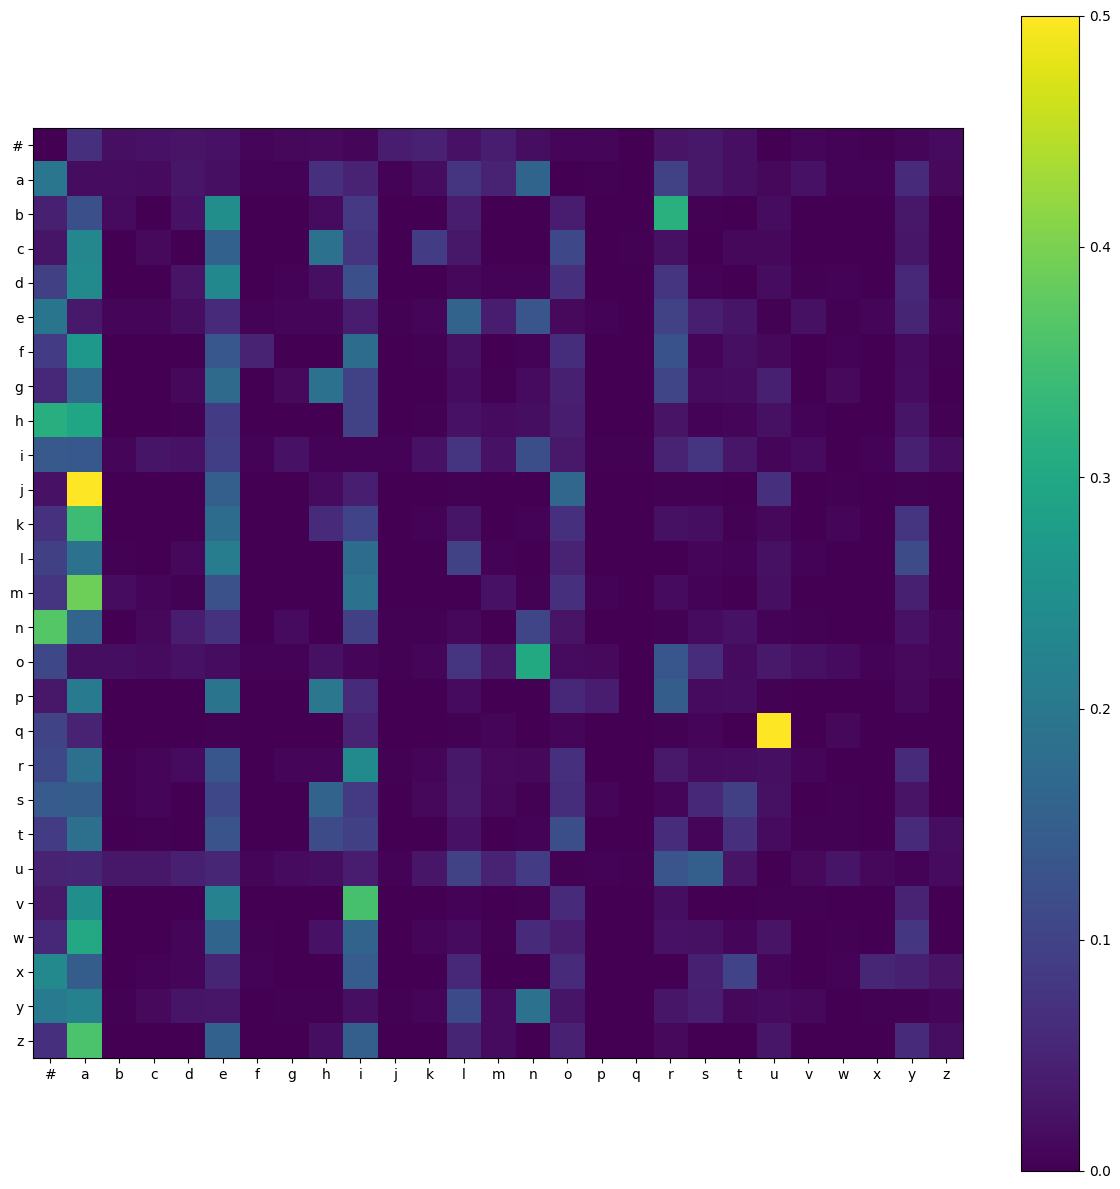

In [8]:


plt.figure(figsize=(15,15))
plt.imshow(transition_mat, vmax=0.5)
plt.xticks(ticks=range(27), labels=unique_alphabet)
plt.yticks(ticks=range(27), labels=unique_alphabet)
plt.colorbar()
None

In [9]:

new_name = '#'

for _ in range(20):
  last_char = new_name[-1]
  last_char_idx = unique_alphabet.index(last_char)
  corresp_transition_row = transition_mat[last_char_idx] # get the probability distribution for next char
  selected_idx = torch.multinomial(corresp_transition_row, 1)  # samples index using the input tensor as a probability distribution
  selected_char = unique_alphabet[selected_idx]
  # print(corresp_transition_row, selected_idx, selected_char)
  if selected_char == '#':
    break
  new_name += selected_char # append new character to the output

print(new_name)

#llpa


In [10]:
# bigram_dict['qu'] / unigram_dict['q']

# RNN
- $h_t = \tanh(\textbf{W}_{hh}h_{t-1} + \textbf{W}_{xh}x_t + b) $
  - $\textbf{W}$: Weight Matrix
  - $b$: bias
  - $x_t$: input vector of time step $t$
  - $h_t$: hidden state (and also output) of time step $t$


In [11]:
import torch.nn as nn
# Linear layer of torch is equivalent to [Wx + b]
# b is bias, so if you use bias=False, it is equivalent to [Wx]

h_dim = 8
i_dim = 5

seq_len = 6

weight_hh = nn.Linear(h_dim, h_dim)
weight_xh = nn.Linear(i_dim, h_dim)

random_input_sequence_tensor = torch.randn(seq_len, i_dim)
random_input_sequence_tensor

tensor([[-0.0911,  0.8030,  2.2585,  0.1999,  0.2923],
        [ 0.8585,  0.8582, -1.0760, -0.7868, -1.0066],
        [ 0.8999, -0.6083, -0.3448,  0.3061, -1.1433],
        [ 1.5534, -0.9673,  0.3798, -1.4058, -0.0659],
        [-1.6255,  1.0567,  0.7554, -2.3202,  1.9318],
        [ 0.0076,  0.9406, -0.3218, -2.1558, -0.3529]])

In [12]:
initial_h = torch.zeros(h_dim)
initial_h

tensor([0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
last_h = initial_h
for t in range(seq_len):
  x_t = random_input_sequence_tensor[t]
  next_h = torch.tanh(weight_hh(last_h) + weight_xh(x_t))
  print(t, next_h)
  last_h = next_h

0 tensor([-0.7788,  0.4643,  0.3672, -0.2271,  0.5915, -0.0351, -0.3650, -0.5553],
       grad_fn=<TanhBackward0>)
1 tensor([-0.1086, -0.8038,  0.8192, -0.9542, -0.1631,  0.7787, -0.0969,  0.4236],
       grad_fn=<TanhBackward0>)
2 tensor([-0.4146,  0.5218,  0.8093, -0.5428,  0.2417,  0.5533, -0.8328,  0.1282],
       grad_fn=<TanhBackward0>)
3 tensor([-0.6654,  0.6914,  0.8806, -0.7587, -0.7313,  0.1121, -0.6236, -0.2783],
       grad_fn=<TanhBackward0>)
4 tensor([-0.9396, -0.8360,  0.8957, -0.6061, -0.7824, -0.8530,  0.8538, -0.9635],
       grad_fn=<TanhBackward0>)
5 tensor([-0.6119, -0.9451,  0.7704, -0.9285, -0.5259, -0.2096, -0.1481, -0.8065],
       grad_fn=<TanhBackward0>)


In [14]:
class RNN(nn.Module):
  def __init__(self, i_dim, h_dim):
    super().__init__()
    self.weight_hh = nn.Linear(h_dim, h_dim)
    self.weight_xh = nn.Linear(i_dim, h_dim)
    self.h_dim = h_dim

  def forward(self, x, last_h=None):
    # assert x.ndim == 2 # T (time step) x C (hidden size)
    output = []
    if x.ndim == 2:
      if last_h is None:
        last_h = torch.zeros(self.h_dim, device=x.device) # initialize last hidden state for the first step
      for t in range(x.shape[0]):
        x_t = x[t]
        next_h = torch.tanh(self.weight_hh(last_h) + self.weight_xh(x_t))
        last_h = next_h
        output.append(next_h)

      # output is list of h_dim vectors with length t
      # len(output) = t
      # len(output[0]) = h_dim
      # i want to make it to [t x h_dim] tensor
      return torch.stack(output, dim=0)
    elif x.ndim == 3: # N (batch) x T (time step) x C (hidden_size)
      batch_size, seq_len, channel_size = x.shape
      if last_h is None:
        last_h = torch.zeros(batch_size, self.h_dim, device=x.device) # N x C
      for t in range(seq_len):
        x_t = x[:, t] # N x C
        next_h = torch.tanh(self.weight_hh(last_h) + self.weight_xh(x_t)) # N x C
        last_h = next_h
        output.append(next_h)
      # output is a list of N x C vectors with length T
      return torch.stack(output, dim=1) # N x [T] x C
    else:
      raise NotImplemented
torch.manual_seed(0) # fix the torch random seed
rnn = RNN(i_dim, h_dim)
rnn(random_input_sequence_tensor), rnn(torch.randn(3, 7, i_dim)).shape

(tensor([[ 0.8297, -0.1678,  0.0831, -0.5634, -0.6523, -0.3261, -0.8722,  0.1788],
         [-0.2217,  0.6083,  0.3371,  0.1115,  0.7342,  0.0885, -0.3147, -0.2930],
         [-0.4162, -0.6081,  0.7596, -0.6706, -0.2821,  0.0634,  0.4230, -0.6757],
         [-0.7089,  0.1019,  0.7302, -0.7009,  0.7286,  0.4758, -0.3059, -0.3725],
         [-0.5278,  0.9778, -0.5341,  0.2978,  0.5470, -0.7281, -0.6665,  0.9190],
         [-0.3381,  0.9023,  0.4039, -0.3532,  0.5850, -0.8277, -0.2862,  0.2220]],
        grad_fn=<StackBackward0>),
 torch.Size([3, 7, 8]))

In [15]:
# convert string into characters

class Str2idx2str:
  def __init__(self, unique_char):
    self.vocab = unique_char
    self.tok2idx = {tok: i for i, tok in enumerate(self.vocab)}
    pass

  def __call__(self, x):
    if isinstance(x, str):
      return [self.tok2idx[char] for char in x]
    elif isinstance(x, list):
      return ''.join([self.vocab[tok_idx] for tok_idx in x])

converter = Str2idx2str(unique_alphabet)

converter('#john#')


class NameDataset:
  def __init__(self, list_of_names):
    self.data = list_of_names
    unique_alphabet = ['%', '#'] + self.get_vocab()
    self.converter = Str2idx2str(unique_alphabet)
    self.vocab_size = len(unique_alphabet)

  def get_vocab(self):
    total_chars = []
    for name in self.data:
      for char in name:
        total_chars.append(char)
    return sorted(list(set(total_chars)))

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    name = self.data[idx]
    tok_appended_name = '#' + name + '#'

    return torch.LongTensor(self.converter(tok_appended_name))



def pad_collate(raw_batch:list):
  max_len = max([len(x) for x in raw_batch])
  output = torch.zeros(len(raw_batch), max_len, dtype=torch.long) # N (batch_size) x T (time step)
  for i, sample in enumerate(raw_batch):
    output[i, :len(sample)] = sample
  return output

dataset = NameDataset(names_list)
dataset[0]

raw_batch = [dataset[i] for i in range(10)]

pad_collate(raw_batch)



tensor([[ 1,  6, 14, 14,  2,  1,  0,  0,  0,  0,  0],
        [ 1, 16, 13, 10, 23, 10,  2,  1,  0,  0,  0],
        [ 1,  2, 23,  2,  1,  0,  0,  0,  0,  0,  0],
        [ 1, 10, 20,  2,  3,  6, 13, 13,  2,  1,  0],
        [ 1, 20, 16, 17,  9, 10,  2,  1,  0,  0,  0],
        [ 1,  4,  9,  2, 19, 13, 16, 21, 21,  6,  1],
        [ 1, 14, 10,  2,  1,  0,  0,  0,  0,  0,  0],
        [ 1,  2, 14,  6, 13, 10,  2,  1,  0,  0,  0],
        [ 1,  9,  2, 19, 17,  6, 19,  1,  0,  0,  0],
        [ 1,  6, 23,  6, 13, 26, 15,  1,  0,  0,  0]])

In [16]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, collate_fn=pad_collate, shuffle=True)
batch = next(iter(dataloader))
batch

tensor([[ 1,  2, 26,  ...,  0,  0,  0],
        [ 1,  8,  6,  ...,  0,  0,  0],
        [ 1,  2, 15,  ...,  0,  0,  0],
        ...,
        [ 1,  2, 13,  ...,  0,  0,  0],
        [ 1,  6, 13,  ...,  0,  0,  0],
        [ 1,  2,  9,  ...,  0,  0,  0]])

In [17]:
class RNNLanguageModel(nn.Module):
  def __init__(self, vocab_size, i_dim, h_dim):
    super().__init__()
    self.char_emb = nn.Embedding(vocab_size, i_dim) # vocab size, i_dim
    self.rnn = RNN(i_dim, h_dim)
    self.proj = nn.Linear(h_dim, vocab_size)

  def forward(self, x):
    char_emb_sequence = self.char_emb(x)
    hidden_state_by_t = self.rnn(char_emb_sequence)
    logit_by_t = self.proj(hidden_state_by_t)

    return logit_by_t


model = RNNLanguageModel(dataset.vocab_size, i_dim=5, h_dim=8)
model(batch).shape



torch.Size([256, 15, 28])

In [18]:
x = batch[0]
input_x = x[:-1]
print(input_x)
target_x = x[1:]
print(target_x)

pred = model(input_x)
print(pred)

prob = torch.log_softmax(pred, dim=-1)
print(prob)
prob_of_target = prob[torch.arange(len(target_x)), target_x]
print(prob_of_target)
negative_log_likelihood = -prob_of_target
negative_log_likelihood

tensor([ 1,  2, 26, 26, 22,  3,  1,  0,  0,  0,  0,  0,  0,  0])
tensor([ 2, 26, 26, 22,  3,  1,  0,  0,  0,  0,  0,  0,  0,  0])
tensor([[ 0.3615,  0.1264, -0.2897, -0.3299, -0.0608, -0.2939,  0.2416,  0.2310,
         -0.1598,  0.4567,  0.4320,  0.0318, -0.1179, -0.0843, -0.3419, -0.0574,
         -0.2704, -0.0283,  0.1989,  0.4047, -0.6068, -0.5474,  0.0044, -0.3877,
         -0.0210,  0.0816, -0.1567,  0.1647],
        [ 0.4765,  0.0822, -0.4351, -0.1891, -0.2410, -0.4047,  0.3922,  0.0594,
         -0.4884,  0.5555,  0.3299,  0.1116, -0.1266, -0.0479, -0.3305, -0.2221,
         -0.2860,  0.2257,  0.2250,  0.6515, -0.7635, -0.4565, -0.2939, -0.5788,
         -0.0316,  0.0864, -0.3563,  0.1910],
        [ 0.1181,  0.9747,  0.5596,  0.5872, -0.2641,  0.5059, -0.2865,  1.1830,
          0.2643, -0.8063,  0.8176, -0.7998,  0.1602, -0.1162, -0.2071, -0.2136,
          0.2268, -0.2304,  0.5628,  0.2629,  0.1020, -0.4941,  0.7052,  0.0657,
         -0.4965,  0.4240,  0.1898,  0.3010],
   

tensor([3.6249, 3.6862, 3.4082, 3.1170, 3.1359, 3.1519, 3.1611, 2.7966, 2.8439,
        2.8670, 2.8619, 2.8636, 2.8635, 2.8628], grad_fn=<NegBackward0>)

In [19]:
# Train the model
# first, define the loss function

def get_nll_loss(pred, target):
  # pred : N x T x V (vocab_size)
  # target: N x T
  if pred.ndim==3:
    pred = pred.flatten(0, 1) # convert N x T x V -> (N x T) x V
  if target.ndim==2:
    target = target.flatten()

  prob = torch.log_softmax(pred, dim=-1)


  prob_of_target = prob[torch.arange(len(target)), target]
  is_not_padded = target != 0
  is_not_padded = is_not_padded.to(pred.device)

  nll = -(prob_of_target * is_not_padded).sum() / sum(is_not_padded)

  return nll

model.cpu()
pred = model(batch[:, :-1]) # we don't have to feed last token, because there is no more token left to predict
target = batch[:, 1:] # shift one time step

get_nll_loss(pred, target)

tensor(3.4073, grad_fn=<DivBackward0>)

In [20]:
class TorchLanguageModel(nn.Module):
  def __init__(self, vocab_size, i_dim, h_dim):
    super().__init__()
    self.char_emb = nn.Embedding(vocab_size, i_dim) # vocab size, i_dim
    self.rnn = nn.GRU(i_dim, h_dim, num_layers=3, batch_first=True)
    self.proj = nn.Linear(h_dim, vocab_size)

  def forward(self, x):
    char_emb_sequence = self.char_emb(x)
    hidden_state_by_t, last_hidden = self.rnn(char_emb_sequence)
    logit_by_t = self.proj(hidden_state_by_t)

    return logit_by_t


In [21]:
from tqdm.auto import tqdm

# model = RNNLanguageModel(dataset.vocab_size, i_dim=32, h_dim=64)
model = TorchLanguageModel(dataset.vocab_size, i_dim=32, h_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epoch = 10
dev = 'cuda'

loss_record = []
model.to(dev)

for epoch in tqdm(range(n_epoch)):
  for batch in dataloader:
    pred = model(batch[:, :-1].to(dev)) # we don't have to feed last token, because there is no more token left to predict
    target = batch[:, 1:] # shift one time step

    loss = get_nll_loss(pred, target)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_record.append(loss.item())

  0%|          | 0/10 [00:00<?, ?it/s]

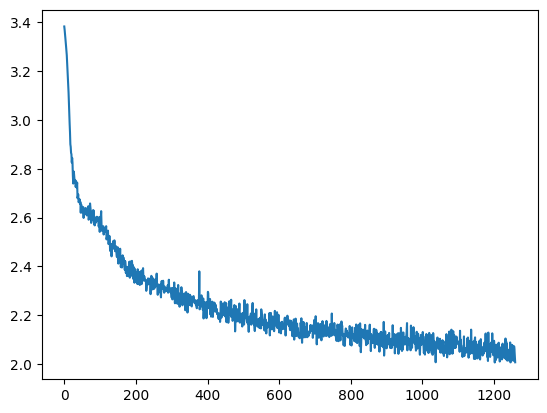

In [22]:
plt.plot(loss_record)

In [58]:
# run language model

output = []

last_token = torch.LongTensor([1])
# last_hidden = torch.zeros(model.rnn.hidden_size)
last_hidden = None
# last_hidden = torch.randn(3,64).tanh()
model.cpu()
model.eval()

with torch.inference_mode(): # do not calculate gradient
  for i in range(20):
    cur_emb = model.char_emb(last_token)
    # last_hidden = model.rnn(cur_emb, last_h=last_hidden)[0]
    # logit = model.proj(last_hidden)
    hidden_states, last_hidden =  model.rnn(cur_emb, last_hidden)
    logit = model.proj(hidden_states[-1]) # select last timestep, and delete timestep axis
    prob = logit.softmax(dim=-1)
    sampled_idx = torch.multinomial(prob, 1)
    # sampled_idx = torch.LongTensor([torch.argmax(prob)])
    last_token = sampled_idx
    if last_token == 1:
      break
    output.append(sampled_idx.item())

dataset.converter(output)


'jaylani'

In [41]:
torch.argmax(prob), prob[1]

(tensor(1), tensor(0.9226))

In [52]:
last_hidden.shape

torch.Size([3, 64])